# Starbucks Capstone Challenge

### Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.



# Problem Statement :
Predicting the purchase offer to which a possible higher level of response or user actions like ‘offer received’, ‘offer viewed’, ‘transaction’ and  ‘offer completed’ can be achieved based on the demographic attributes of the customer and other attributes of the companies purchase offers. 


## Importing Libraries & loading datasets :

In [3]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

In [7]:
portfolio.head(1) 

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


In [8]:
profile.head(1) 

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN


In [9]:
transcript.head(1) 

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


## Data Accessing and Cleaning :

### 1. Portfolio Data

#### Dataset overview :

**portfolio.json**

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

 There are three types of offers that can be sent: `buy-one-get-one (BOGO)`, `discount`, and `informational`.
- In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. 
- In a discount, a user gains a reward equal to a fraction of the amount spent.
- In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. 

Offers can be delivered via multiple channels.

In [10]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [11]:
portfolio.shape

(10, 6)

In [12]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [13]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [14]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

### - Data Cleaning

- create a copy of the original dataframe for further implementation .
- convert the column 'Channels' into 4 different channel on the basis of different types of channel .
- rename the column name from 'ID' to 'offer_id' .

In [15]:
df1 = portfolio.copy()

In [16]:
dummy = pd.get_dummies(df1.channels.apply(pd.Series).stack()).sum(level=0)
df1 = pd.concat([df1, dummy], axis=1)
df1 = df1.drop(columns='channels')

In [17]:
df1 = df1.rename(columns={'id':'offer_id'})

In [18]:
df1

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


### 2. Profile Data
#### Dataset overview :

**profile.json**

- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

In [19]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [20]:
profile.shape

(17000, 5)

In [21]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [22]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [23]:
profile.duplicated().sum()

0

## - Data Cleaning
- create a copy of the original dataframe for further implementation .
- convert the datatype of 'became_member_on' column and sort the date into proper format .
- change the column name from 'ID' to 'customer_id' .

In [24]:
df2 = profile.copy()

In [25]:
df2['became_member_on'] = pd.to_datetime(df2['became_member_on'], format='%Y%m%d')

In [26]:
df2 = df2.rename(columns={'id':'customer_id'})

In [27]:
df2.head(10)

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN


In [28]:
type(df2.became_member_on[0])

pandas._libs.tslibs.timestamps.Timestamp

### 3. Transcript Data
#### Dataset overview :

**transcript.json**

- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

In [29]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [30]:
transcript.shape

(306534, 4)

In [31]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [32]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [33]:
transcript['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [34]:
transcript['value'].value_counts()   
# the error occur because Column Vlaue contains dictonary in each row .

TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
                                                    ...  
{'amount': 439.14}                                      1
{'amount': 42.75}                                       1
{'amount': 650.75}                                      1
{'amount': 943.4}                                       1
{'amount': 44.21}                                       1
Name: value, Length: 5121, dtype: int64

In [35]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [36]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

## - Data Cleaning
- create a copy of the original dataframe for further implementation .
- change the column name from 'person' to 'customer_id' .
- convert the column 'Event' into 4 different columns on the basis of different types of event .
- convert the column 'Values' into 2 different column  .

In [37]:
df3 = transcript.copy()

In [38]:
df3 = df3.rename(columns={'person':'customer_id'})

In [39]:
df3['event'] = df3['event'].str.replace(' ', '-')


In [40]:
df3['event'].value_counts()

transaction        138953
offer-received      76277
offer-viewed        57725
offer-completed     33579
Name: event, dtype: int64

In [41]:
dummy = pd.get_dummies(df3['event'])
df3 = pd.concat([df3, dummy], axis=1 )

In [42]:
df3.head()

,customer_id,event,value,time,offer-completed,offer-received,offer-viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer-received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


In [43]:
df3['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df3.value]
df3['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in df3.value]

In [44]:
df3 = df3.drop(columns='value')

In [45]:
df3.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer-received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


## - Data Cleaning :

- Concatenate all the three dataset together .
- Fixed the Offer_ids .
- fixed even_ids

In [46]:
t_p = pd.merge(df3, df2, on='customer_id')


In [47]:
t_p

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,None,19.89,F,75,2017-05-09,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,None,17.78,F,75,2017-05-09,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-09-26,NaN
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer-viewed,594,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-09-26,NaN
306531,3045af4e98794a04a5542d3eac939b1f,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,58,2016-10-20,78000.0
306532,3045af4e98794a04a5542d3eac939b1f,offer-viewed,576,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,58,2016-10-20,78000.0


In [48]:
df = pd.merge(t_p, df1, on='offer_id', how='left')
df

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,None,19.89,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,None,17.78,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,...,2017-09-26,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer-viewed,594,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,...,2017-09-26,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306531,3045af4e98794a04a5542d3eac939b1f,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,...,2016-10-20,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306532,3045af4e98794a04a5542d3eac939b1f,offer-viewed,576,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,...,2016-10-20,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [49]:
offer_id = df['offer_id'].unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', None,
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '3f207df678b143eea3cee63160fa8bed',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

In [50]:
offer_dict = pd.Series(offer_id ).to_dict()
offer_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: None,
 2: '5a8bc65990b245e5a138643cd4eb9837',
 3: 'ae264e3637204a6fb9bb56bc8210ddfd',
 4: 'f19421c1d4aa40978ebb69ca19b0e20d',
 5: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 6: '3f207df678b143eea3cee63160fa8bed',
 7: '2906b810c7d4411798c6938adc9daaa5',
 8: 'fafdcd668e3743c1bb461111dcafc2a4',
 9: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 10: '2298d6c36e964ae4a3e7e9706d1fb8c2'}

In [51]:
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 None: 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 '2906b810c7d4411798c6938adc9daaa5': 7,
 'fafdcd668e3743c1bb461111dcafc2a4': 8,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 9,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 10}

In [52]:
df['offer_id'] = df['offer_id'].map(offer_dict)
df.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,1,19.89,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,1,17.78,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df['offer_id'] = df['offer_id'].replace(1, np.nan)

In [54]:
df.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,NaN,19.89,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,NaN,17.78,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df['offer_id'].unique()

array([ 0., nan,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [56]:
event_ids = df['event'].unique()
event_ids

array(['offer-received', 'offer-viewed', 'transaction', 'offer-completed'],
      dtype=object)

In [57]:
event_dict = pd.Series(event_ids).to_dict()
event_dict

{0: 'offer-received',
 1: 'offer-viewed',
 2: 'transaction',
 3: 'offer-completed'}

In [58]:
event_dict = dict([(value, key) for key, value in event_dict.items()]) 
event_dict

{'offer-received': 0,
 'offer-viewed': 1,
 'transaction': 2,
 'offer-completed': 3}

In [59]:
#map event_ids to the encoded event ids
df['event_id'] = df['event'].map(event_dict)

In [60]:
df.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,income,reward,difficulty,duration,offer_type,email,mobile,social,web,event_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,NaN,19.89,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,3
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,NaN,17.78,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [61]:
df.shape

(306534, 22)

In [62]:
df.columns

Index(['customer_id', 'event', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       306534 non-null  object        
 1   event             306534 non-null  object        
 2   time              306534 non-null  int64         
 3   offer-completed   306534 non-null  uint8         
 4   offer-received    306534 non-null  uint8         
 5   offer-viewed      306534 non-null  uint8         
 6   transaction       306534 non-null  uint8         
 7   offer_id          167581 non-null  float64       
 8   amount            138953 non-null  float64       
 9   gender            272762 non-null  object        
 10  age               306534 non-null  int64         
 11  became_member_on  306534 non-null  datetime64[ns]
 12  income            272762 non-null  float64       
 13  reward            167581 non-null  float64       
 14  diff

In [64]:
df.to_csv('data/data.csv', index=False)

In [65]:
data = pd.read_csv('data/data.csv')

## Data Exploration and Data Visualization :

In [66]:
data.age.describe()

count    306534.000000
mean         60.909367
std          26.032030
min          18.000000
25%          43.000000
50%          57.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

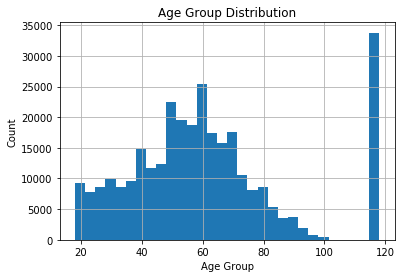

In [67]:
data.age.hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

### Observation :

- Outlier is present Age > 115 is present is high amount , which does not make sense .
- Average Aged user is middle age ie. around 50-62 years 

In [68]:
data.income.describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

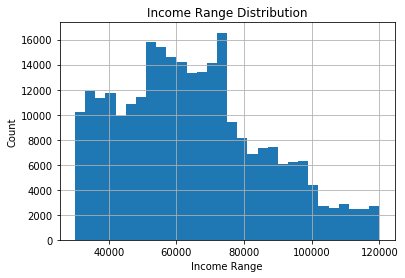

In [69]:
data.income.hist(bins = 30);
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');

### Observation :

- Average income user is middle income group ie. 65000-70000 

In [70]:
data.gender.value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [71]:
male_proportion  = data.gender.value_counts()[0] / data.shape[0]*100
female_proportion = data.gender.value_counts()[1] / data.shape[0]*100
others_proportion = data.gender.value_counts()[2] / data.shape[0]*100

male_proportion ,female_proportion ,others_proportion

(50.79045065147749, 36.89672271265177, 1.2954517280301696)

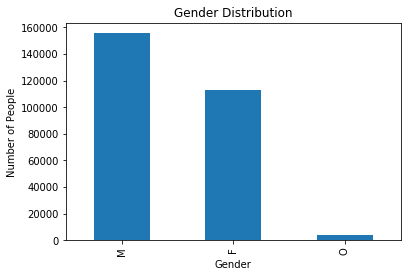

In [72]:
ax = data.gender.value_counts()
ax.plot(kind='bar')
plt.ylabel('Number of People')
plt.xlabel('Gender')
plt.title('Gender Distribution');

### Observation :

- males are more than 50 percent of users .

In [73]:
offer_received = data[data['offer-received'] == 1].offer_type.value_counts()
offer_viewed = data[data['offer-viewed'] == 1].offer_type.value_counts()
offer_completed = data[data['offer-completed'] == 1].offer_type.value_counts()

offer_received , offer_viewed , offer_completed 

(discount         30543
 bogo             30499
 informational    15235
 Name: offer_type, dtype: int64,
 bogo             25449
 discount         21445
 informational    10831
 Name: offer_type, dtype: int64,
 discount    17910
 bogo        15669
 Name: offer_type, dtype: int64)

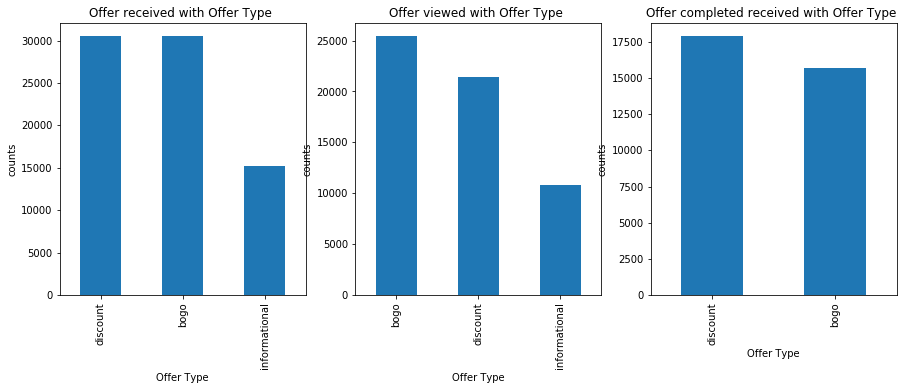

In [74]:
plt.subplot(131)
offer_received = data[data['offer-received'] == 1].offer_type.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type ');

plt.subplot(132)
offer_viewed = data[data['offer-viewed'] == 1].offer_type.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer viewed with Offer Type ');

plt.subplot(133)
offer_completed = data[data['offer-completed'] == 1].offer_type.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer completed received with Offer Type ');


In [75]:
# For BOGO Offer :

R = offer_received[1] 
V = offer_viewed[0] 
C = offer_completed[1] 

view_prop = V/R
com_prop = C/R
R , V , C , view_prop , com_prop

(30499, 25449, 15669, 0.8344208006819895, 0.5137545493294862)

In [76]:
# For DISCOUNT Offer :

R = offer_received[0] 
V = offer_viewed[1] 
C = offer_completed[0] 

view_prop = V/R
com_prop = C/R
R , V , C , view_prop , com_prop

(30543, 21445, 17910, 0.702124873129686, 0.5863864060504862)

### Observation :

- BOGO offers are highly demanding , 30499 users received BOGO offer  25449 viewed the offer and 15669 completed it .
- the percentage of BOGO Offer viewer is 83 percent .
- the percentage of DISCOUNT Offer viewer is 70 percent .

In [77]:
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()

offer_received , offer_viewed , offer_completed 

(0.0     7677
 5.0     7668
 3.0     7658
 10.0    7646
 7.0     7632
 2.0     7618
 6.0     7617
 8.0     7597
 9.0     7593
 4.0     7571
 Name: offer_id, dtype: int64,
 10.0    7337
 8.0     7327
 9.0     7298
 4.0     7264
 3.0     6716
 2.0     6687
 0.0     4171
 6.0     4144
 7.0     4118
 5.0     2663
 Name: offer_id, dtype: int64,
 8.0     5317
 10.0    5156
 0.0     4354
 4.0     4296
 7.0     4017
 3.0     3688
 5.0     3420
 9.0     3331
 Name: offer_id, dtype: int64)

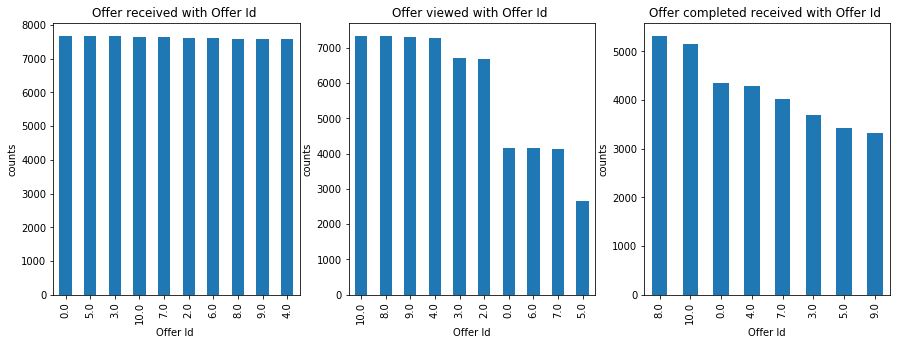

In [78]:
plt.subplot(131)
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id ')
plt.title('Offer received with Offer Id ');

plt.subplot(132)
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer viewed with Offer Id ');

plt.subplot(133)
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer completed received with Offer Id ');

### Observation :

- evry offer_id received eual offers .
- Viewing ratio decreased for some offer_ids like 0 , 6 , 7 , 5
- Offer completed ration is quite decent .

In [79]:
data[data['offer_type']=='bogo'].groupby('customer_id')['offer-received'].count()

customer_id
0009655768c64bdeb2e877511632db8f    3
00116118485d4dfda04fdbaba9a87b5c    4
0011e0d4e6b944f998e987f904e8c1e5    3
0020c2b971eb4e9188eac86d93036a77    4
0020ccbbb6d84e358d3414a3ff76cffd    6
                                   ..
fff3ba4757bd42088c044ca26d73817a    3
fff7576017104bcc8677a8d63322b5e1    6
fff8957ea8b240a6b5e634b6ee8eafcf    2
fffad4f4828548d1b5583907f2e9906b    9
ffff82501cea40309d5fdd7edcca4a07    3
Name: offer-received, Length: 14992, dtype: int64

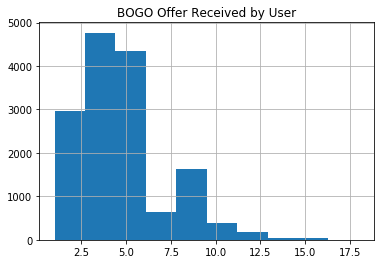

In [80]:
data[data['offer_type']=='bogo'].groupby('customer_id')['offer-received'].count().hist();
plt.title('BOGO Offer Received by User');

### Observation :

- the BOGO offer is received by quite decent amount of users .

In [81]:
data[data['offer_type']=='informational'].groupby('customer_id')['offer-viewed'].count()

customer_id
0009655768c64bdeb2e877511632db8f    4
0011e0d4e6b944f998e987f904e8c1e5    4
0020c2b971eb4e9188eac86d93036a77    2
0020ccbbb6d84e358d3414a3ff76cffd    2
003d66b6608740288d6cc97a6903f4f0    4
                                   ..
ffecb1f8543f4bf7bade023de366d6bf    2
fff0f0aac6c547b9b263080f09a5586a    4
fff3ba4757bd42088c044ca26d73817a    3
fff8957ea8b240a6b5e634b6ee8eafcf    1
fffad4f4828548d1b5583907f2e9906b    2
Name: offer-viewed, Length: 10547, dtype: int64

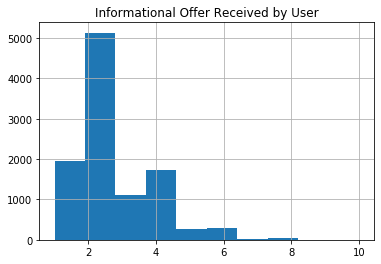

In [82]:
data[data['offer_type']=='informational'].groupby('customer_id')['offer-viewed'].count().hist();
plt.title('Informational Offer Received by User');

### Observation :

- the ratio is 2 - 4 offer viewed is very high .
- the difference is extremely high .

In [83]:
data[data['offer_type']=='discount'].groupby('customer_id')['offer-completed'].count()

customer_id
0009655768c64bdeb2e877511632db8f     5
0011e0d4e6b944f998e987f904e8c1e5     6
0020c2b971eb4e9188eac86d93036a77     5
0020ccbbb6d84e358d3414a3ff76cffd     3
003d66b6608740288d6cc97a6903f4f0     8
                                    ..
fff29fb549084123bd046dbc5ceb4faa     3
fff3ba4757bd42088c044ca26d73817a     6
fff7576017104bcc8677a8d63322b5e1     6
fff8957ea8b240a6b5e634b6ee8eafcf     2
ffff82501cea40309d5fdd7edcca4a07    15
Name: offer-completed, Length: 14945, dtype: int64

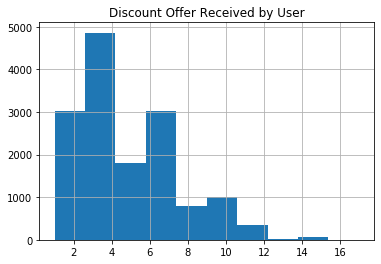

In [84]:
data[data['offer_type']=='discount'].groupby('customer_id')['offer-completed'].count().hist();
plt.title('Discount Offer Received by User');

### Observation :

- the ratio od 2 - 4 times offer completed by the customer is very high .

## Modeling and Predictions :

- apply one hot encoding for Gender column and Offer_type Column ( Pre Model Prepration )

In [85]:
genders = {'O': 0, 'M': 1, 'F': 2}
data['gender'] = data['gender'].map(genders)

In [86]:
data.offer_type.value_counts()

bogo             71617
discount         69898
informational    26066
Name: offer_type, dtype: int64

In [87]:
offers = {'bogo': 0, 'discount': 1, 'informational': 2}
data['offer_type'] = data['offer_type'].map(offers)

In [88]:
data.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,income,reward,difficulty,duration,offer_type,email,mobile,social,web,event_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0.0,NaN,2.0,...,100000.0,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0.0,NaN,2.0,...,100000.0,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0,1
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,NaN,19.89,2.0,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0.0,NaN,2.0,...,100000.0,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0,3
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,NaN,17.78,2.0,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [89]:
data.columns

Index(['customer_id', 'event', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [90]:
X = data.drop(['customer_id', 'event_id' , 'event' , 'became_member_on','offer-completed', 'offer-received',
       'offer-viewed', 'transaction'], axis=1)
Y = data['event_id']

In [91]:
X.head()

,time,offer_id,amount,gender,age,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0,0.0,NaN,2.0,75,100000.0,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0
1,6,0.0,NaN,2.0,75,100000.0,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0
2,132,NaN,19.89,2.0,75,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132,0.0,NaN,2.0,75,100000.0,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0
4,144,NaN,17.78,2.0,75,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
Y.head()

0    0
1    1
2    2
3    3
4    2
Name: event_id, dtype: int64

In [93]:
X.shape , Y.shape

((306534, 14), (306534,))

### Feature Scaling : 

#### Standardization & Normalization

Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. It is also known as Min-Max scaling.

Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

In [94]:
class_name =['offer recieved', 'offer viewed', 'transaction', 'offer completed']

In [95]:
#split the dataset into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [96]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((214573, 14), (91961, 14), (214573,), (91961,))

In [97]:
std = StandardScaler()

In [98]:
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))

X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

C:\Users\Swati\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Swati\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [99]:
X_test.income = std.transform(X_test.income.values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test.age.values.reshape(-1, 1))

X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

C:\Users\Swati\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Swati\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [100]:
X_train.shape, X_test.shape

((214573, 14), (91961, 14))

- converting the pandas dataframe into numpy array .

In [101]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

#### Build a Model :

In [102]:
ann = keras.models.Sequential()

In [103]:
ann.add(keras.layers.Dense(6, activation='relu'))
ann.add(keras.layers.Dense(6, activation='relu'))
ann.add(keras.layers.Dense(4, activation = 'softmax'))

In [104]:
ann.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])

In [105]:
ann_history = ann.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100)


Train on 214573 samples, validate on 91961 samples
Epoch 1/15
214573/214573 [==============================] - 13s 62us/step - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 2/15
214573/214573 [==============================] - 12s 54us/step - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 3/15
214573/214573 [==============================] - 11s 51us/step - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 4/15
214573/214573 [==============================] - 12s 54us/step - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 5/15
214573/214573 [==============================] - 12s 54us/step - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 6/15
214573/214573 [==============================] - 12s 55us/step - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 7/15
214573/214573 [==============================] - 13s 62us/step - loss: na

In [106]:
ann.summary()       
# Summary of our model 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 90        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 28        
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


In [107]:
ann.history.params

{'batch_size': 100,
 'epochs': 15,
 'steps': None,
 'samples': 214573,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

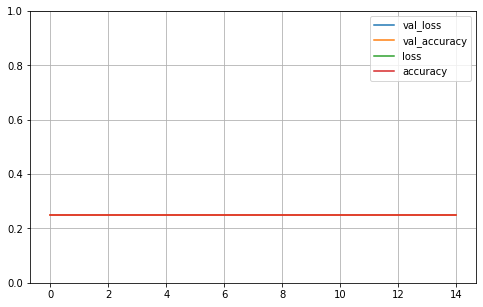

In [108]:
pd.DataFrame(ann.history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)               # Y AXIS RANGE LIMIT 
plt.show()

### Evaluation Martrix :

- evaluation can be done on the basis of accuracy obtained by the model and by Loss produced .

In [109]:
ann.evaluate(X_test , y_test)

91961/91961 [==============================] - 5s 57us/step


[nan, 0.25066059827804565]

## Observation :

- the test accuracy is only 25% .
- and the rate of accuracy remains constant throught the process .
- this model needs some correction and improvement for better result .

## Refinement : Improving Prediction Model 

- let's create a new X dataframe with highly recommended features ,and highly dependent features .
- more hidden layers .
- more hidden units .

In [110]:
data.columns

Index(['customer_id', 'event', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [111]:
X = data.drop(['customer_id', 'event_id' ,  'amount','event' , 'became_member_on','offer-completed', 'offer-received',
       'offer-viewed','email', 'mobile', 'social', 'web', 'time','transaction', 'duration'], axis=1)
Y = data['event_id']

In [112]:
X.head()

,offer_id,gender,age,income,reward,difficulty,offer_type
0,0.0,2.0,75,100000.0,5.0,5.0,0.0
1,0.0,2.0,75,100000.0,5.0,5.0,0.0
2,NaN,2.0,75,100000.0,NaN,NaN,NaN
3,0.0,2.0,75,100000.0,5.0,5.0,0.0
4,NaN,2.0,75,100000.0,NaN,NaN,NaN


In [113]:
X.shape , Y.shape

((306534, 7), (306534,))

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [115]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((214573, 7), (91961, 7), (214573,), (91961,))

In [116]:
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))

X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

C:\Users\Swati\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Swati\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [117]:
X_test.income = std.transform(X_test.income.values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test.age.values.reshape(-1, 1))

X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

C:\Users\Swati\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Swati\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [118]:
# Convert the pandas dataframe into numpy array

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

#### Build a model :

In [119]:
ann = keras.models.Sequential()

In [133]:
ann.add(keras.layers.Dense(32, input_dim=7, kernel_initializer = 'normal' ,activation='relu'))
ann.add(keras.layers.Dense(15, kernel_initializer = 'normal' ,activation='relu'))
ann.add(keras.layers.Dense(10, kernel_initializer = 'normal' ,activation='relu'))
ann.add(keras.layers.Dense(6, kernel_initializer = 'normal' ,activation='relu'))
ann.add(keras.layers.Dense(4, kernel_initializer = 'normal' ,activation = 'softmax'))

In [134]:
ann.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])

In [135]:
ann_history = ann.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100 , verbose = 2)

Train on 214573 samples, validate on 91961 samples
Epoch 1/15
 - 22s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 2/15
 - 20s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 3/15
 - 20s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 4/15
 - 19s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 5/15
 - 20s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 6/15
 - 21s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 7/15
 - 21s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 8/15
 - 20s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 9/15
 - 21s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 10/15
 - 21s - loss: nan - accuracy: 0.2481 - val_loss: nan - val_accuracy: 0.2507
Epoch 11/15
 - 21s - loss: nan - accuracy: 0.2481 - val_loss: nan - 

In [136]:
ann.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)                495       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                160       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                

In [126]:
ann.history.params

{'batch_size': 100,
 'epochs': 15,
 'steps': None,
 'samples': 214573,
 'verbose': 2,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

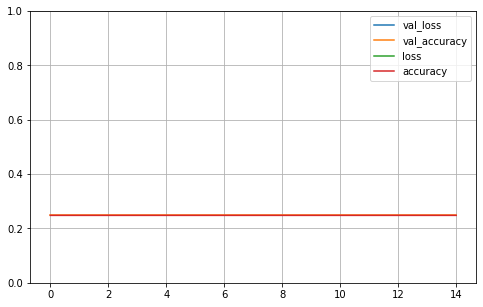

In [127]:
pd.DataFrame(ann.history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)               # Y AXIS RANGE LIMIT 
plt.show()

### Evaluation Martrix :

- evaluation can be done on the basis of accuracy obtained by the model and by Loss produced .

In [128]:
ann.evaluate(X_test , y_test)

91961/91961 [==============================] - 6s 68us/step


[nan, 0.25066059827804565]

In [129]:
# TO PERFORM OF CHECK THE RESULT IN NEW DATA SET
# AS WE DON'T HAVE NEW DATA SET , CREATE ONE FROM TEST DATA SET
# HOW TO PREDICT THE PROBABILITY and CLASSES IN UNSEEN DATA


x_new = X_test[:3]

In [130]:
# PROBABILITY OF EACH SET

y_prob = ann.predict(x_new)
y_prob.round(2)                        # RESULT IN 2 DECIMAL PLACE 

array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]], dtype=float32)

In [131]:
# CLASS OF EACH SET 

y_pred = ann.predict_classes(x_new)
y_pred

array([0, 0, 0], dtype=int64)

In [132]:
np.array(class_name)[y_pred]

array(['offer recieved', 'offer recieved', 'offer recieved'], dtype='<U15')

## Observation :

- there is no difference between the 1st and 2nd model .
- the events are wrongly predicted as 'offer received'

# Conclusion :

- I found this project challenging, mainly due to the structure of the data in the transcript dataset.
- Majority classes are performing well but the minorities are not.Problem of imbalanced dataset 
- Most of the events are wrongly predicted as 'offer received'; offer received is the most occuring event or class.

**Main challenges and potential improvement:**
 Analysing and building the deep learning models .
 
 - The main goal I chose, was to build something practical the company could use make their choices more efficient.
 - But the results of the model seems like not so good . There is no change in rate of accuracy it remain constant .

# References : 

- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
- https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.merge.html
- https://stackoverflow.com/questions/37600711/pandas-split-column-into-multiple-columns-by-comma
- https://www.researchgate.net/post/Is_there_a_universal_method_rule_to_choose_the_activation_function_for_a_MLP_neural_network#:~:text=For%20binary%20classification%20(i.e.%20problems,entropy%20as%20the%20cost%20function.
- https://stackoverflow.com/questions/55324762/the-added-layer-must-be-an-instance-of-class-layer-found-tensorflow-python-ke
- https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
- https://www.tensorflow.org/tutorials/keras/classification

In [137]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Starbucks_Capstone_notebook.ipynb'])

0